# **4.1 Downloading the Data**


Download the excel files of Spain and US's data from the International Monetary Fund’s “International Financial Statistics” website (https://data.imf.org/?sk=4c514d48-b6ba-49ed-8ab9-52b0c1a0179b)

# **4.2 Cleaning the Data**

In [53]:
#import libraries
from google.colab import files
uploaded = files.upload()

Saving International_Financial_Statistics_ Spain.xlsx to International_Financial_Statistics_ Spain (2).xlsx
Saving International_Financial_Statistics_ United States.xlsx to International_Financial_Statistics_ United States (2).xlsx


In [54]:
#import files 
import pandas as pd
df_US = pd.read_excel((uploaded['International_Financial_Statistics_ United States.xlsx']), header=[1], index_col=[1])
df_Spain = pd.read_excel((uploaded['International_Financial_Statistics_ Spain.xlsx']), header=[1], index_col=[1])

In [55]:
#Remove country column, will incorporate country name into row titles. Makes calculations easier
df_US = df_US.drop('Unnamed: 0', axis=1)
df_Spain = df_Spain.drop('Unnamed: 0', axis=1)

In [56]:
#Rename row names to include country it represents
df_US = df_US.rename(index={'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar': 'US International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
                            'Prices, Consumer Price Index, All items, Index' : 'US Prices, Consumer Price Index, All items, Index'})
df_Spain = df_Spain.rename(index={'Economic Activity, Industrial Production, Index' : 'Spain Economic Activity, Industrial Production, Index',
                                  'Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate': 'Spain Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate',
                                  'International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar' : 'Spain International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar',
                                  'Prices, Consumer Price Index, All items, Index' : 'Spain Prices, Consumer Price Index, All items, Index'})

In [57]:
#Transpose dataframes to make easier to do calculations
df_US = df_US.T
df_Spain = df_Spain.T

In [58]:
#merge datasets
merged_DS = pd.concat([df_Spain, df_US], sort=False, axis=1)

In [59]:
#Format the month and year variable into a date format
#Extract worded dates (e.g. Jan 1960) from index as series
dates = merged_DS.index
#Turn worded dates into date format (e.g. 1960-01-01) and then only take year/month
dates = pd.DatetimeIndex(data=dates).to_period("M")
#Turn index of dates into series to be merged with dataframe. Save values as strings to be processed in graphs
dates = dates.to_series().astype(str)
#Set index of merged dataframe as new date series
merged_DS.set_axis(dates, inplace=True)

All series are renamed to be representative of their data

Constructing variables for Spain

In [60]:
#series of Spanish exchange rates
exchange_rates_Spain = merged_DS.iloc[:,1]

In [61]:
#calculate log exchange rate (4.2 (i))
import numpy as np
log_exchange_rates_Spain = np.log(exchange_rates_Spain.astype(float))
log_exchange_rates_Spain = log_exchange_rates_Spain.rename("Spain Log Exchange Rates")

In [62]:
#The difference in the log exchange rate versus the previous month (4.2 (ii))
diff_in_the_log_exchange_rates = log_exchange_rates_Spain.diff()
diff_in_the_log_exchange_rates = diff_in_the_log_exchange_rates.rename("Spain Difference in Log Exchange Rates")

In [63]:
#series of Spanish monthly CPI
CPI_Spain = merged_DS.iloc[:,3]

In [64]:
#Spanish monthly inflation rate (4.2 (iii)) as a %.
monthly_inflation_rate_Spain = CPI_Spain.pct_change() * 100
monthly_inflation_rate_Spain = monthly_inflation_rate_Spain.rename("Spain Monthly Inflation Rate (%)")

In [65]:
#series of Spanish industrial production. Take from beginning of 1961 - assume series only begins here as first year is blank.
industrial_production_Spain = merged_DS.iloc[12:,0]

In [66]:
#Log industrial production (4.2 (iv))
log_industrial_production_Spain = np.log(industrial_production_Spain.astype(float))
log_industrial_production_Spain = log_industrial_production_Spain.rename("Spain Log Industrial Production")

In [67]:
#Monthly growth in industrial production (4.2 (v)) as a %.
monthly_growth_industrial_production_Spain = industrial_production_Spain.pct_change() * 100
monthly_growth_industrial_production_Spain = monthly_growth_industrial_production_Spain.rename("Spain Monthly Growth Industrial Production (%)")

In [68]:
#Yearly growth in industrial production (4.2 (vi)) as a %.
yearly_growth_industrial_production_Spain = industrial_production_Spain.pct_change(periods = 12) * 100
yearly_growth_industrial_production_Spain = yearly_growth_industrial_production_Spain.rename("Spain Yearly Growth Industrial Production (%)")

In [69]:
#An index of the value of Spanish international reserves (value of reserves at January 1960 = 100) (4.2 (vii))
index_of_international_reserves_Spain = ((merged_DS.iloc[:, 2])/merged_DS.iloc[0, 2])*100
index_of_international_reserves_Spain = index_of_international_reserves_Spain.rename("Spain Index of International Reserves, Base Month: 1960-01 = 100")

Constructing variables for US

In [70]:
#series of US monthly CPI
CPI_US = merged_DS.iloc[:,-1]

In [71]:
#US monthly inflation rate (4.2, US (i)) as a %.
monthly_inflation_rate_US = CPI_US.pct_change() * 100
monthly_inflation_rate_US = monthly_inflation_rate_US.rename("US Monthly Inflation Rate (%)")

In [72]:
#An index of the value of US international reserves (value of reserves at January 1960 = 100) (4.2, US (ii))
index_of_international_reserves_US = ((merged_DS.iloc[:, -2])/merged_DS.iloc[0, -2])*100
index_of_international_reserves_US = index_of_international_reserves_US.rename("US Index of International Reserves, Base Month: 1960-01 = 100")

Identify outliers

In [73]:
#create a function to check for outliers with boxplots
def outlier_check(series):
  #sort series so quartiles are calculated correctly
  series_sort = series.sort_values()
  #calculate quartiles to calculate inter-quartile range. Use nanquintile to ignore NaN values in industrial production series
  Q3 = np.nanquantile(series_sort, 0.75)
  Q1 = np.nanquantile(series_sort, 0.25)
  IQR = Q3 - Q1
  #calculate bounds for outliers as 1.5*IQR away from Q1 and Q3
  lower_range = Q1 - 1.5 * IQR
  upper_range = Q3 + 1.5 * IQR
  #for loop to select all data points outside this 1.5*IQR from whiskers range
  outlier =[]
  for x in series_sort:
      if ((x> upper_range) or (x<lower_range)):
          outlier.append(x)
  print('number of outliers in the dataset is', len(outlier))
  print(outlier)
  #plot box plot of the data
  import plotly.express as px
  fig = px.box(series_sort, width = 141*3, height = 500)

  fig.show()

In [74]:
#Identify the outliers for monthly changes in log exchange rates in Spain
outlier_check(log_exchange_rates_Spain)

number of outliers in the dataset is 0
[]


In [75]:
#Identify the outliers for monthly differences in log exchange rates in Spain
outlier_check(diff_in_the_log_exchange_rates)

number of outliers in the dataset is 104
[-0.06339470527118252, -0.0627629167542274, -0.04978346661426247, -0.04771430363378215, -0.04618582378959779, -0.045986482596621414, -0.04306185965103371, -0.04041849446423562, -0.040284370985673945, -0.039228040522916174, -0.03836650113139761, -0.038137888729217195, -0.03784821968896512, -0.03765646752264207, -0.0357048833502418, -0.03563351958143812, -0.03507910258848046, -0.03419719522120168, -0.0333298991267057, -0.0327710492470672, -0.031847910194801266, -0.03146572700541572, -0.030859477841003624, -0.030112052058171024, -0.029392762625901625, -0.028534516658623055, -0.02835122223420683, -0.024963405806237127, -0.024927928441304203, -0.024734410063447676, -0.023636046693273016, -0.022951743638167876, -0.02265221438316445, -0.02252775904669857, -0.022123352054162382, -0.02129744439049741, -0.02094584878825323, -0.0207576000544627, -0.020724071840869662, -0.019821853642183918, -0.018339076094469497, -0.018069244751313995, -0.01784836968785175

In [76]:
#Identify the outliers for monthly inflation rate in Spain
outlier_check(monthly_inflation_rate_Spain)

number of outliers in the dataset is 7
[-1.846368312097879, 2.7957753366298244, 2.875121806778802, 3.243423693718417, 3.2572664989482414, 3.2787157119642085, 4.582094670899295]


In [77]:
#Identify the outliers for log industrial production in Spain
outlier_check(log_industrial_production_Spain)

number of outliers in the dataset is 0
[]


In [78]:
# Identify the outliers for monrhlt growth in industrial production in Spain
outlier_check(monthly_growth_industrial_production_Spain)

number of outliers in the dataset is 45
[-48.46743295019156, -46.210526315789465, -44.870349492671956, -43.55971896955503, -43.409316154608526, -42.62759924385628, -42.54716981132073, -41.34509371554578, -39.92890995260668, -39.69010727056027, -38.002296211251476, -34.517766497461935, -34.29256594724224, -31.5521628498728, -31.052631578947288, -30.16997167138805, -20.54073670840132, -20.41212121212125, -20.15277465738048, -19.654687813692096, 19.02815622161644, 21.172248803827998, 21.68452161063914, 21.9032322826741, 23.732572877059653, 23.944850872256684, 24.39841608285116, 29.572961863439073, 30.959520239880113, 54.766734279918936, 54.92700729927, 57.55813953488382, 60.1851851851853, 61.52416356877328, 62.213740458015046, 68.23308270676682, 70.21696252465507, 71.16968698517276, 73.41513292433545, 74.71264367816053, 75.8893280632413, 78.98423817863389, 82.778864970646, 83.19502074688789, 85.31598513011156]


In [79]:
#Identify the outliers for yearly growth in industrial production in Spain
outlier_check(yearly_growth_industrial_production_Spain)

number of outliers in the dataset is 2
[-20.55424698360816, 24.45907808090326]


In [80]:
#Identify the outliers in an index of international reserves for Spain
outlier_check(index_of_international_reserves_Spain)

number of outliers in the dataset is 38
[13824.844750709957, 14779.321218779656, 15100.874038932488, 15581.809964266267, 15963.304884765967, 16294.747427462058, 16556.954644819012, 16588.00813899322, 16610.357937344463, 16611.05698648322, 16859.243882410432, 17375.02737893468, 17706.886609649657, 17865.257550398543, 17956.877651937553, 18105.84700993262, 18217.05633028927, 18728.52952034661, 18752.065193778883, 19238.089839893477, 19924.90236238532, 19986.154369213393, 20004.016042406267, 20017.616101336225, 20025.617334622704, 20080.760780279485, 20122.76118615884, 20164.66263339661, 20452.508383935325, 20501.13039413704, 20637.002440030345, 20795.84160990116, 22650.535897507725, 22844.513854649227, 23085.917475359704, 23788.858616691028, 24036.41028653232, 24183.631902222187]


In [81]:
#Identify the outliers for monthly inflation rate in the US
outlier_check(monthly_inflation_rate_US)

number of outliers in the dataset is 14
[-0.4574565416284204, -0.40816326530624947, 1.1713030746705932, 1.199999999999668, 1.2145748987855587, 1.2500000000001288, 1.2526096033404377, 1.271186440678096, 1.2747875354107485, 1.287553648068318, 1.413881748071888, 1.4341590612779065, 1.5209125475283969, 1.8058690744921169]


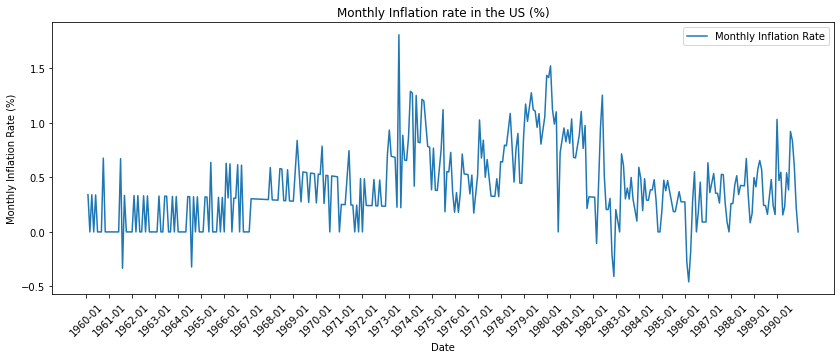

In [82]:
#Plot the graph now to visualise the outliers and see if there is a pattern/ explanation  
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(monthly_inflation_rate_US, label='Monthly Inflation Rate')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Monthly Inflation rate in the US (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Inflation Rate (%)')

ax.legend()
plt.show()

In [83]:
#Identify the outliers for an index of international reserves in the US
outlier_check(index_of_international_reserves_US)

number of outliers in the dataset is 18
[290.3601621735526, 295.47404335572884, 318.5453822482138, 329.67855332097395, 337.8313335513533, 345.3449088512932, 347.3707323710077, 351.5504698385472, 355.16740591555265, 355.2596763224341, 358.63678275855506, 359.89609534152413, 362.7242942663434, 367.39208010661747, 372.58494062719933, 385.751982399709, 386.71671504284035, 387.9124066274228]


Interpolate missing data

In [84]:
#Interpolate all NaN values to be the mean of its adjacent values
series_to_interpolate = [diff_in_the_log_exchange_rates, monthly_inflation_rate_Spain, monthly_growth_industrial_production_Spain, log_industrial_production_Spain, yearly_growth_industrial_production_Spain, index_of_international_reserves_Spain, monthly_inflation_rate_US, index_of_international_reserves_US]
for i in series_to_interpolate:
  i = i.interpolate()
#Set first value to be equal to second month's value. Interpolation doesn't work as no value before first value
diff_in_the_log_exchange_rates.iloc[0] = diff_in_the_log_exchange_rates.iloc[1]
monthly_inflation_rate_Spain.iloc[0] = monthly_inflation_rate_Spain.iloc[1]
monthly_inflation_rate_US.iloc[0] = monthly_inflation_rate_US.iloc[1]
#Cannot interpolate first year of Spanish Industrial Production. Assume industrial production data series starts in 1961, set first year values to blank
merged_DS.iloc[0:12, 0] = ''

Construct a series for monthly real exchange exchange rate growth

In [85]:
#Nominal exchange rate Spain|US is in national currency (Peseta); how many Peseta for every USD. Represents E(PTS/USD)
#Create a series of real exchange rates with formula: %change monthly real exchange rate Spain|US = %change monthly nominal exchange rate Spain|US - monthly Spain inflation + monthly US inflation
#Construct a series for monthly real exchange exchange rate growth (4.2). Values are decimal, not percent, i.e., 0.03 instead of 3%
monthly_real_exch_rate_growth = (diff_in_the_log_exchange_rates*100 - monthly_inflation_rate_Spain + monthly_inflation_rate_US)
#Shows the change in how many "Spanish baskets" must be exchanged for one "US basket" over time

# **4.3 End Product**


In [86]:
#define date transforming function
def dater(series):
  #Format the month and year variable into a date format
  #Extract worded dates (e.g. Jan 1960) from index as series
  dates = series.index
  #Turn worded dates into date format (e.g. 1960-01-01) and then only take year/month
  dates = pd.DatetimeIndex(data=dates).to_period("M")
  #Turn index of dates into series to be merged with dataframe. Save values as strings to be processed in graphs
  dates = dates.to_series().astype(str)
  #Set index of series as new date series
  series.set_axis(dates, inplace=True)

In [87]:
#Transform dates index of all series into date format
dater(log_exchange_rates_Spain)
dater(diff_in_the_log_exchange_rates)
dater(monthly_inflation_rate_Spain)
dater(log_industrial_production_Spain)
dater(monthly_growth_industrial_production_Spain)
dater(yearly_growth_industrial_production_Spain)
dater(index_of_international_reserves_Spain)
dater(monthly_inflation_rate_US)
dater(index_of_international_reserves_US)

In [88]:
#End Product. Change Jupyter settings to display more than 10 rows. Combined merged_DS with all series computed above.
final_DS = pd.concat([merged_DS, log_exchange_rates_Spain, diff_in_the_log_exchange_rates, monthly_inflation_rate_Spain, log_industrial_production_Spain, monthly_growth_industrial_production_Spain, yearly_growth_industrial_production_Spain, index_of_international_reserves_Spain, monthly_inflation_rate_US, index_of_international_reserves_US], sort=False, axis=1)
pd.options.display.max_rows = 400

final_DS

,"Spain Economic Activity, Industrial Production, Index","Spain Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate","Spain International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar","Spain Prices, Consumer Price Index, All items, Index","US International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar","US Prices, Consumer Price Index, All items, Index",Spain Log Exchange Rates,Spain Difference in Log Exchange Rates,Spain Monthly Inflation Rate (%),Spain Log Industrial Production,Spain Monthly Growth Industrial Production (%),Spain Yearly Growth Industrial Production (%),"Spain Index of International Reserves, Base Month: 1960-01 = 100",US Monthly Inflation Rate (%),"US Index of International Reserves, Base Month: 1960-01 = 100"
1960-01,,60.000000,233.000000,2.857368,21478.100000,13.436946,4.094345,0.000000,-0.081128,NaN,NaN,NaN,100.000000,0.341297,100.000000
1960-02,,60.000000,253.000000,2.855049,21395.700000,13.482806,4.094345,0.000000,-0.081128,NaN,NaN,NaN,108.583691,0.341297,99.616353
1960-03,,60.000000,299.000000,2.851573,21344.700000,13.482806,4.094345,0.000000,-0.121770,NaN,NaN,NaN,128.326180,0.000000,99.378902
1960-04,,60.000000,326.000000,2.853891,21278.000000,13.528666,4.094345,0.000000,0.081292,NaN,NaN,NaN,139.914163,0.340136,99.068353
1960-05,,60.000000,360.000000,2.845198,21234.300000,13.528666,4.094345,0.000000,-0.304609,NaN,NaN,NaN,154.506438,0.000000,98.864890
1960-06,,60.000000,406.000000,2.842878,21169.800000,13.574526,4.094345,0.000000,-0.081515,NaN,NaN,NaN,174.248927,0.338983,98.564584
1960-07,,60.000000,427.000000,2.841719,20999.400000,13.574526,4.094345,0.000000,-0.040791,NaN,NaN,NaN,183.261803,0.000000,97.771218
1960-08,,60.000000,455.000000,2.847516,20803.400000,13.574526,4.094345,0.000000,0.203996,NaN,NaN,NaN,195.278970,0.000000,96.858661
1960-09,,60.000000,479.000000,2.864902,20430.000000,13.574526,4.094345,0.000000,0.610582,NaN,NaN,NaN,205.579399,0.000000,95.120146
1960-10,,60.000000,527.000000,2.872438,20068.200000,13.666246,4.094345,0.000000,0.263041,NaN,NaN,NaN,226.180258,0.675676,93.435639


# **5.3 Analysis**

5.3.1 Exchange Rate and International Reserve Graphs

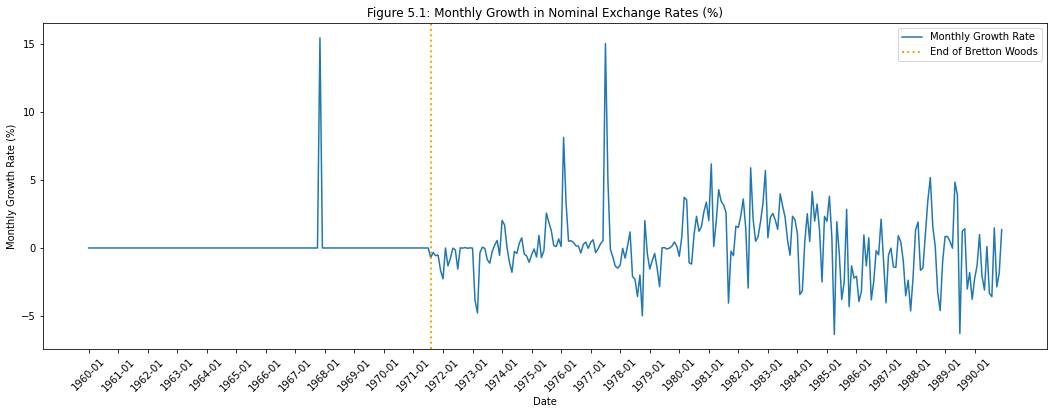

In [89]:
# Time series graph of the monthly growth in nominal exchange rates in Spain, versus the US dollar. 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(diff_in_the_log_exchange_rates*100, label='Monthly Growth Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.1: Monthly Growth in Nominal Exchange Rates (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Growth Rate (%)')

ax.legend()
plt.show()

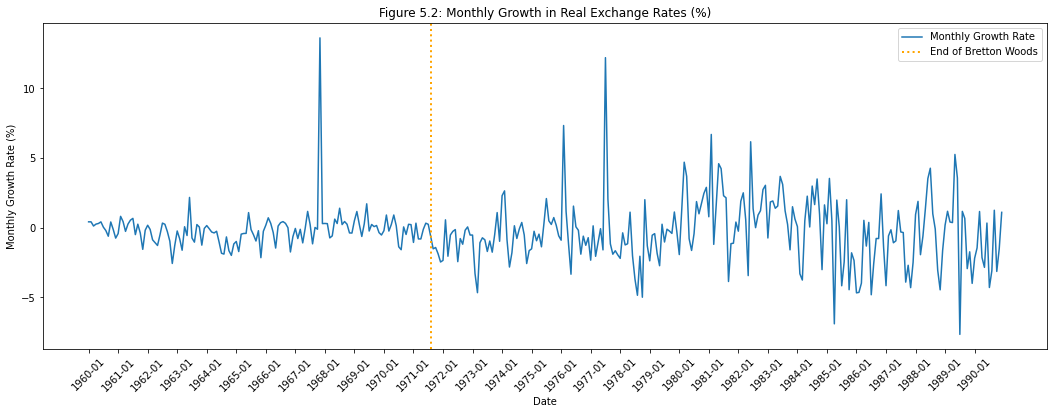

In [90]:
#Time series graph of the monthly growth in real exchange rate Spain to US

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(monthly_real_exch_rate_growth, label='Monthly Growth Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.2: Monthly Growth in Real Exchange Rates (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Growth Rate (%)')

ax.legend()
plt.show()

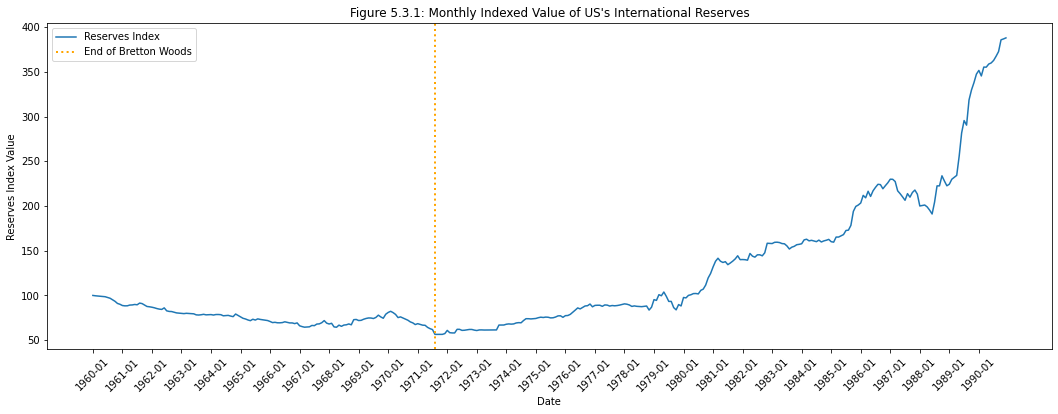

In [91]:
# Time series graph of the monthly indexed value of international reserves of US
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(index_of_international_reserves_US, label='Reserves Index')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.3.1: Monthly Indexed Value of US\'s International Reserves')
ax.set_xlabel('Date')
ax.set_ylabel('Reserves Index Value')

ax.legend()
plt.show()

 5.3.2 Inflation and Industrial Production Graphs

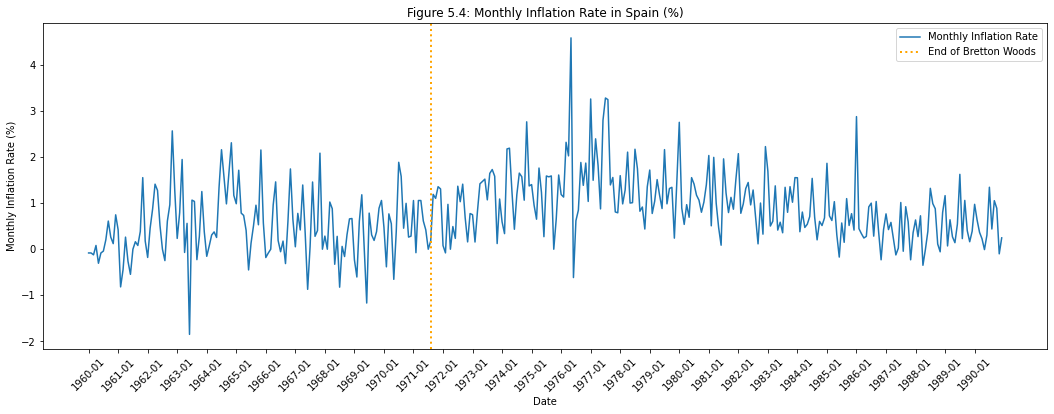

In [92]:
# Time series graph of the monthly inflation rate in Spain. 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(monthly_inflation_rate_Spain, label='Monthly Inflation Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.4: Monthly Inflation Rate in Spain (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Inflation Rate (%)')

ax.legend()
plt.show()

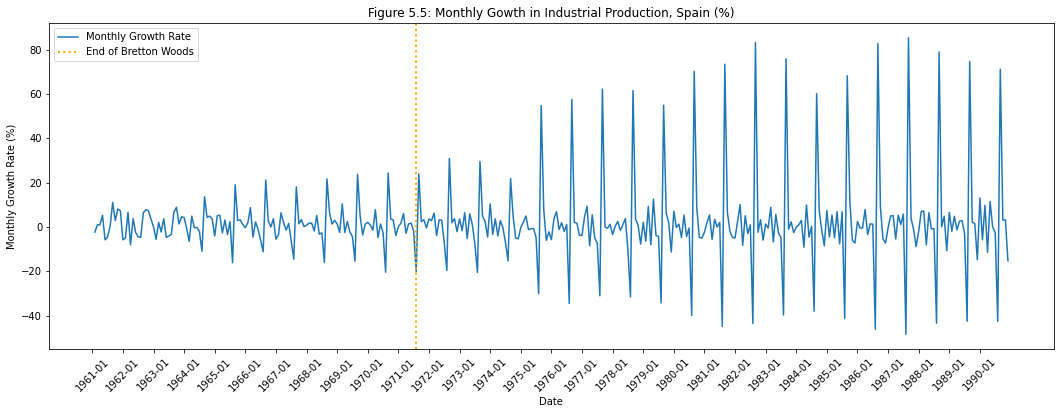

In [93]:
# Time series graph of the monthly growth in industrial production in Spain. 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(monthly_growth_industrial_production_Spain, label='Monthly Growth Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.5: Monthly Gowth in Industrial Production, Spain (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Growth Rate (%)')

ax.legend()
plt.show()

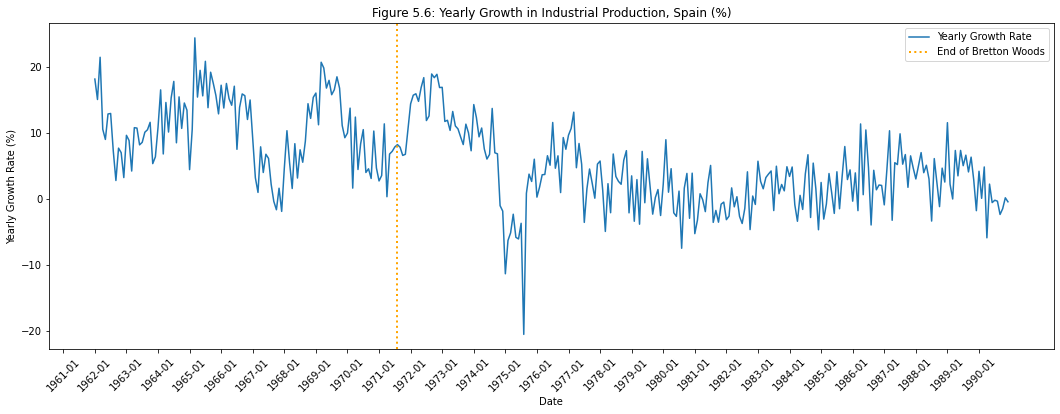

In [94]:
# Time series graph of the growth in industrial production compared to 12 months ago in Spain. 
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(yearly_growth_industrial_production_Spain, label='Yearly Growth Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.6: Yearly Growth in Industrial Production, Spain (%)')
ax.set_xlabel('Date')
ax.set_ylabel('Yearly Growth Rate (%)')

ax.legend()
plt.show()

5.3.3 Comparison Statistics

In [95]:
#SD of the monthly growth of Spain nominal exchange rates versus the US dollar
#Note, changing to % as well by multiplying by 100
#For after bretton woods we exclude July 1971 to October 1970
monthly_nominal_growth_sd_before = diff_in_the_log_exchange_rates.loc[:'1970-09'].std() * 100
print(monthly_nominal_growth_sd_before)

#For after bretton woods we exclude August 1971 to May 1972
monthly_nominal_growth_sd_after = diff_in_the_log_exchange_rates.loc['1972-05':].std() * 100
print(monthly_nominal_growth_sd_after)

#Ratio of after to before 
print(monthly_nominal_growth_sd_after / monthly_nominal_growth_sd_before)

1.357221057792946
2.495516422144907
1.838695625753853


In [96]:
#SD of the monthly growth of Spain real exchange rates versus the US dollar
#For after bretton woods we exclude July 1971 to October 1970
monthly_real_growth_sd_before = monthly_real_exch_rate_growth.loc[:'1970-09'].std()
print(monthly_real_growth_sd_before)

#For after bretton woods we exclude August 1971 to May 1972
monthly_real_growth_sd_after = monthly_real_exch_rate_growth.loc['1972-05':].std()
print(monthly_real_growth_sd_after)

#Ratio of after to before
print(monthly_real_growth_sd_after / monthly_real_growth_sd_before)

1.454816436310555
2.478327090820494
1.703532506895223


In [97]:
#SD of the monthly inflation rates in Spain
#For after bretton woods we exclude July 1971 to October 1970
monthly_inflation_before_sd = monthly_inflation_rate_Spain.loc[:'1970-09'].std()
print(monthly_inflation_before_sd)

#For after bretton woods we exclude August 1971 to May 1972
monthly_inflation_after_sd = monthly_inflation_rate_Spain.loc['1972-05':].std()
print(monthly_inflation_after_sd)

#Ratio of after to before
print(monthly_inflation_after_sd / monthly_inflation_before_sd)

0.739673421046131
0.7335967756560974
0.9917846914366082


In [98]:
#SD of the difference between the inflation in Spain versus the United States
#First, let's calculate the difference between the inflation in Spain versus the United States
difference_in_inflation = monthly_inflation_rate_Spain - monthly_inflation_rate_US

#Now we an calculate the standard deviation of this
#For after bretton woods we exclude July 1971 to October 1970
difference_in_inflation_before_sd = difference_in_inflation.loc[:'1970-09'].std()
print(difference_in_inflation_before_sd)

#For after bretton woods we exclude August 1971 to May 1972
difference_in_inflation_after_sd = difference_in_inflation.loc['1972-05':].std()
print(difference_in_inflation_after_sd)

#Ratio of after to before 
print(difference_in_inflation_after_sd / difference_in_inflation_before_sd)


0.8034985957843741
0.7387211072780842
0.9193807072642681


In [99]:
#SD of the 12-monthly industrial production growth
#For after bretton woods we exclude July 1971 to October 1970
yearly_growth_before_sd = yearly_growth_industrial_production_Spain.loc[:'1970-09'].std()
print(yearly_growth_before_sd)

#For after bretton woods we exclude August 1971 to May 1972
yearly_growth_after_sd = yearly_growth_industrial_production_Spain.loc['1972-05':].std()
print(yearly_growth_after_sd)

#Ratio of after to before
print(yearly_growth_after_sd / yearly_growth_before_sd)

5.660710026009615
5.615441497395841
0.9920030299369202


5.3.4 What Are The Effects of Exchange Rates?

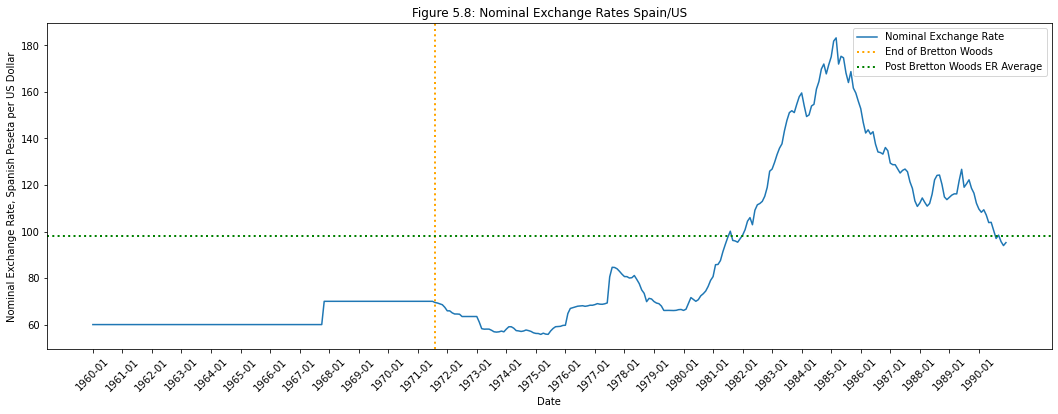

In [100]:
#Time series graph of nominal exchange rates in Spain, versus the US dollar with post Bretton Woods Nominal Exchange Rate average.
         
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(exchange_rates_Spain, label='Nominal Exchange Rate')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')
ax.axhline(y=np.average(exchange_rates_Spain.loc['1971-08':]), color='green', ls=':', lw=2, label='Post Bretton Woods ER Average')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.8: Nominal Exchange Rates Spain/US')
ax.set_xlabel('Date')
ax.set_ylabel('Nominal Exchange Rate, Spanish Peseta per US Dollar')

ax.legend()
plt.show()

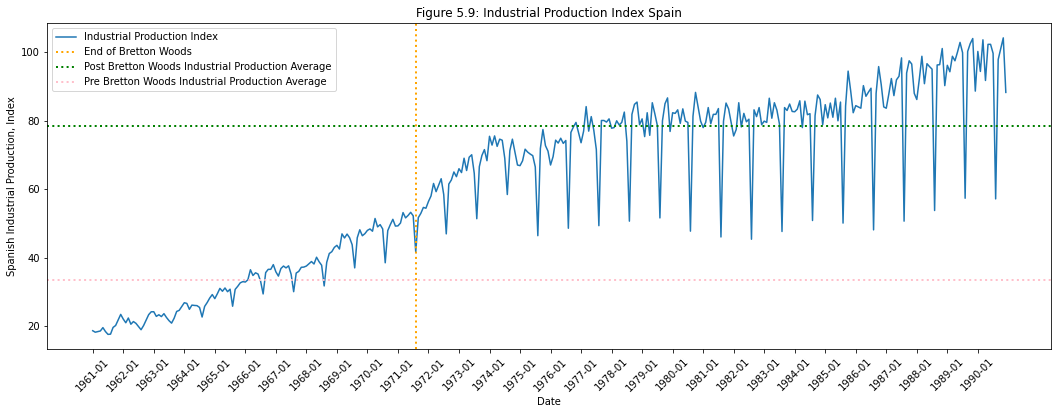

In [101]:
#Time series graph of industrial production in Spain, versus the US dollar with post Bretton Woods Nominal Exchange Rate average.
         
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(industrial_production_Spain, label='Industrial Production Index')
ax.axvline(x='1971-08', color='orange', ls=':', lw=2, label='End of Bretton Woods')
ax.axhline(y=np.average(industrial_production_Spain.loc['1971-08':]), color='green', ls=':', lw=2, label='Post Bretton Woods Industrial Production Average')
ax.axhline(y=np.average(industrial_production_Spain.loc[:'1971-08']), color='pink', ls=':', lw=2, label='Pre Bretton Woods Industrial Production Average')

plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::12])

ax.set_title('Figure 5.9: Industrial Production Index Spain')
ax.set_xlabel('Date')
ax.set_ylabel('Spanish Industrial Production, Index')

ax.legend()
plt.show()